In [3]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [4]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [5]:
dtxsids = ['2-Amino-4,6-Dinitrotoluene',
'2,4,6-Trinitrotoluene',
'2-Methyl-5-nitroaniline',
'Isopropalin',
'Pendimethalin',
'Trifluralin'
]

smiles = ['CC1=C(C=C(C=C1N)[N+]([O-])=O)[N+]([O-])=O',
'CC1=C(C=C(C=C1[N+]([O-])=O)[N+]([O-])=O)[N+]([O-])=O',
'CC1=C(N)C=C(C=C1)[N+]([O-])=O',
'CCCN(CCC)C1=C(C=C(C=C1[N+]([O-])=O)C(C)C)[N+]([O-])=O',
'CCC(CC)NC1=C(C=C(C)C(C)=C1[N+]([O-])=O)[N+]([O-])=O',
'CCCN(CCC)C1=C(C=C(C=C1[N+]([O-])=O)C(F)(F)F)[N+]([O-])=O',

]

In [6]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import grakel
import networkx as nx

MOLS = dict(zip(dtxsids, smiles))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,2048)) for i in MOLS.values()])
FP0.index = MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]



In [7]:
from scipy.spatial.distance import pdist, squareform

In [8]:
D_mgrn = pd.DataFrame(squareform(pdist(FP0, 'jaccard')), columns = FP0.index, index = FP0.index)

In [9]:
S_mgrn = 1-D_mgrn

<Axes: >

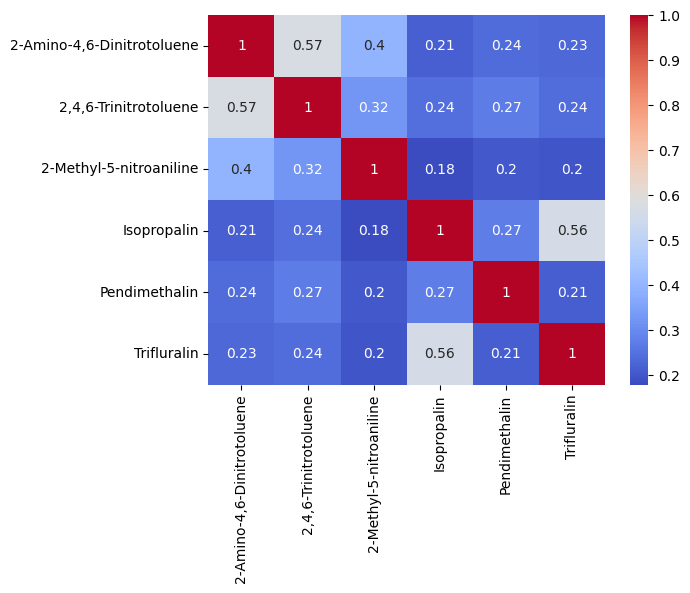

In [12]:
sns.heatmap(S_mgrn, cmap = 'coolwarm', annot = True)

In [13]:
def transform_matrix(df):
    a = df.where(np.triu(np.ones(df.shape)).astype('bool'))
    a = df.stack().reset_index()
    a = a.where(a.iloc[:,0] != a.iloc[:,1])
    a = a.dropna()
    a.columns = ['target', 'source', 'jaccard']
    a = a.sort_values(by = 'jaccard', ascending = False)
    a['bins'] = pd.cut(x = a['jaccard'], bins = [-0.000001,0.1,0.3, 0.5,0.7,1])
    return a, a['bins'].value_counts(dropna = False, normalize = True)

## ToxPrints

In [35]:
txps = pd.read_excel(raw_dir/'toxprints-pprtv.xlsx')

In [36]:
txps.columns

Index(['DTXCID', 'DTXSID', 'CASRN', 'Name', 'SMILES',
       'atom:element_main_group', 'atom:element_metal_group_I_II',
       'atom:element_metal_group_III', 'atom:element_metal_metalloid',
       'atom:element_metal_poor_metal',
       ...
       'ring:polycycle_bicyclo_propene', 'ring:polycycle_spiro_[2.2]pentane',
       'ring:polycycle_spiro_[2.5]octane', 'ring:polycycle_spiro_[4.5]decane',
       'ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane',
       'ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene',
       'ring:polycycle_tricyclo_[3.7.7]bullvalene',
       'ring:polycycle_tricyclo_[3.7.7]semibullvalene',
       'ring:polycycle_tricyclo_adamantane',
       'ring:polycycle_tricyclo_benzvalene'],
      dtype='object', length=734)

In [37]:
S_txp = (txps
         .drop_duplicates(subset = ['DTXSID'], keep = 'first')
 .set_index('Name')
 .drop(['DTXCID', 'CASRN', 'DTXSID', 'SMILES'], axis = 1)
.dropna(how = 'any')
 .pipe(lambda df : 1- pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index))
 .rename_axis(index=None, columns=None) 
)

In [38]:
S_txp.shape

(6, 6)

<Axes: >

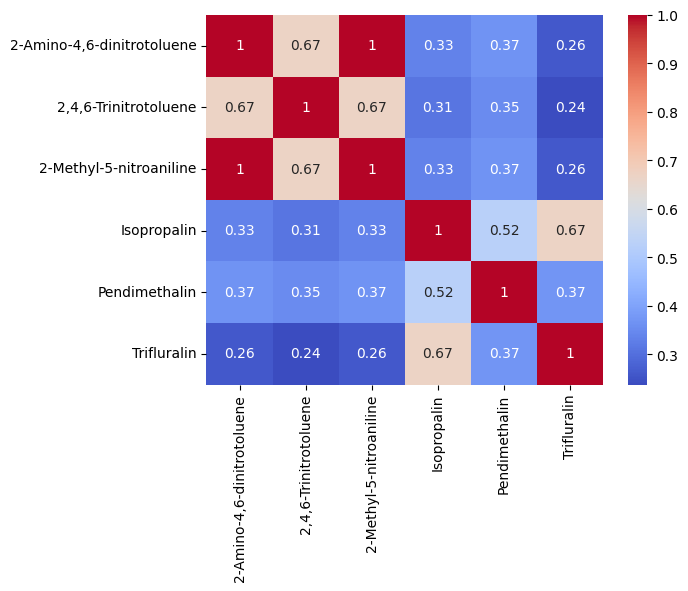

In [39]:
sns.heatmap(S_txp,cmap = 'coolwarm',annot=True)

In [14]:
import grakel
import networkx as nx

In [15]:
#| echo: false
def smile_to_mol_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    g = nx.Graph()
    
    # Add nodes with atom properties
    for atom in mol.GetAtoms():
        node_label = {
    "symbol": atom.GetSymbol(),
    "degree": atom.GetDegree(),
    "hybridization": str(atom.GetHybridization()),
    "aromaticity": atom.GetIsAromatic(),
    "formal_charge": atom.GetFormalCharge(),
    "implicit_hydrogen_count": atom.GetTotalNumHs()
}
        g.add_node(atom.GetIdx(), atom_label = str(node_label))

    # Add edges with bond properties
    for bond in mol.GetBonds():
        g.add_edge(bond.GetBeginAtomIdx(), 
                   bond.GetEndAtomIdx(), 
                   bond_type=str(bond.GetBondType()))

    return g

In [17]:
graphs = {k:smile_to_mol_graph(v) for k,v in zip(dtxsids, smiles)}

In [18]:
grakel_graphs = grakel.graph_from_networkx(list(graphs.values()),node_labels_tag='atom_label') 



In [19]:


# Compute the WL kernel
wl_kernel = grakel.WeisfeilerLehman(base_graph_kernel=grakel.VertexHistogram,normalize=True)
kernel_matrix = wl_kernel.fit_transform(grakel_graphs)

In [20]:
p1 = pd.DataFrame(kernel_matrix, columns = graphs.keys(), index = graphs.keys())



<Axes: >

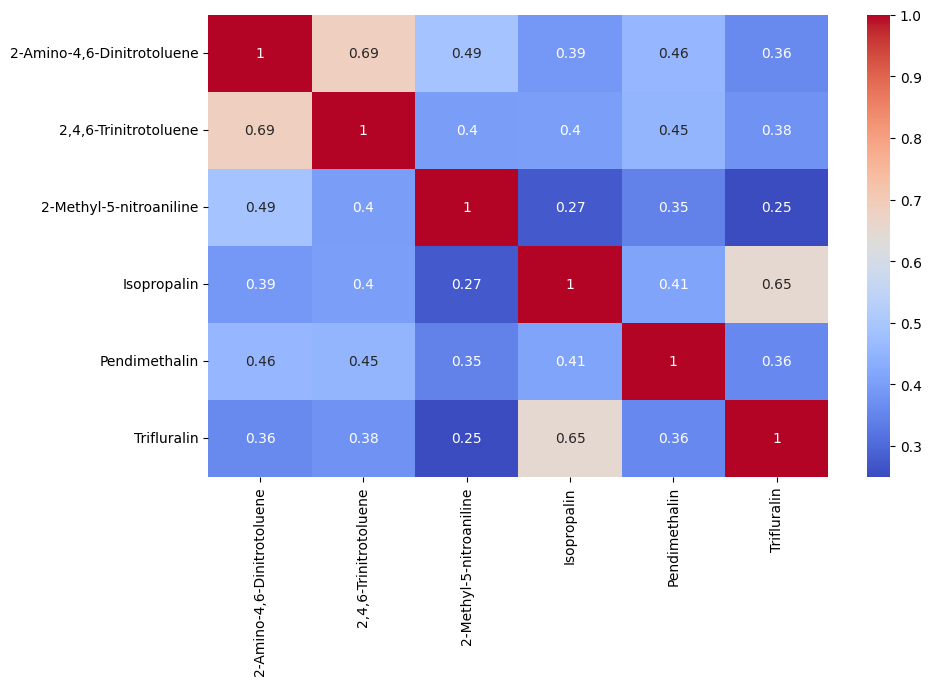

In [22]:
plt.figure(figsize = (10,6))
sns.heatmap(p1, cmap = 'coolwarm', annot=True)

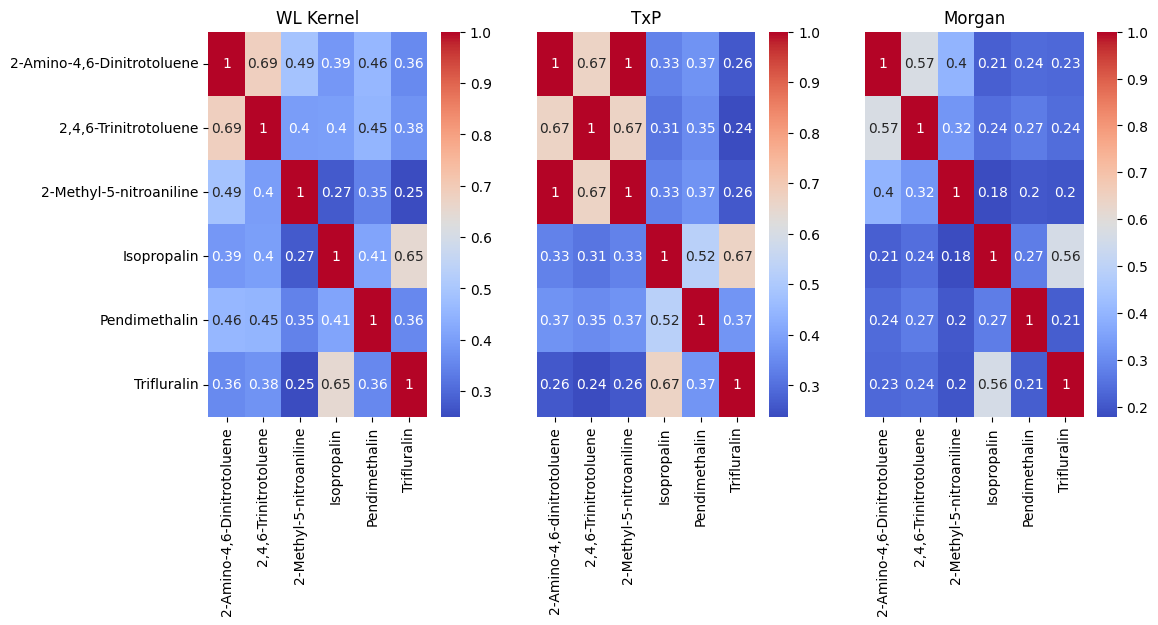

In [44]:
f, ax = plt.subplots(1,3, figsize=(12,5))
sns.heatmap(p1 , cmap = 'coolwarm',  annot=True, ax= ax[0])
ax[0].set_title("WL Kernel")
sns.heatmap(S_txp , cmap = 'coolwarm',annot = True, ax= ax[1], yticklabels=False)
ax[1].set_title("TxP")
sns.heatmap(S_mgrn, cmap = 'coolwarm',  annot = True, ax= ax[2],yticklabels=False)
ax[2].set_title("Morgan")
f.savefig(figures_dir/'pprtv_sim.png', dpi = 300, bbox_inches='tight')